In [2]:
import os
import numpy as np
import pandas as pd
import math
import statistics as stat
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from id3 import Id3Estimator, export_text
from id3 import export_graphviz

import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))
missing_values = ['n/a', 'na', 'nan', 'N/A', 'NA', 'NaN', 'NAN', '--', 'Missing', 'missing', 'MISSING', 'Unknown',
                  'Weet ik niet', 'None', 'ONBEKEND', '"ontbrekend"', '"onbekend"', 'onbekend']

In [3]:
def entropy(column: pd.Series, base=None):
    # Determine the fractions for all column values
    fractions = column.value_counts(normalize=True, sort=False)
    base = 2 if base is None else base
    return -(fractions * np.log(fractions) / np.log(base)).sum()

def information_gain(df: pd.DataFrame, s: str, target: str):
    # calculate entropy of parent table
    entropy_parent = entropy(df[target])
    child_entropies = []
    child_weights = []
    # compute entropies of child tables
    for (label, p) in df[s].value_counts().items():
        child_df = df[df[s] == label]
        child_entropies.append(entropy(child_df[target]))
        child_weights.append(int(p))
    # calculate the difference between parent entropy and weighted child entropies
    return entropy_parent - np.average(child_entropies, weights=child_weights)

def infGainAll(df,target):
    out = pd.Series()
    for label in df.columns:
        line = pd.Series([information_gain(df, label, target)],index=[label])
        out = pd.concat([out,line])
        # print('{}: {}'.format(label, ))
    return out.sort_values(ascending=False)


# Vraag 2: Play ball (Basic)
1. Lees het bestand playball.csv. Deze tabel laat toe om te beslissen of er een wedstrijd gespeeld zal worden, afhankelijk van de weersomstandigheden.

In [5]:
df = pd.read_csv('./data/playBall.csv', delimiter=',')
df

,outlook,temperature,humidity,wind,playBall
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


2. Bereken de entropie van deze tabel. Schrijf ook de formule op.

In [8]:
#14
total = 14
# yes
one =df.playBall[df['playBall'] == 'Yes'].count()
#no
two = df.playBall[df['playBall'] == 'No'].count()

-(one/total)*math.log2(one/total)-(two/total)*math.log2(two/total)

0.9402859586706311

3. Bereken de gain voor iedere kolom. Schrijf telkens de formule op.
4. Welke kolom kies je voor de eerste node?

In [9]:
infGainAll(df,'playBall')

playBall       0.940286
outlook        0.246750
humidity       0.151836
wind           0.048127
temperature    0.029223
dtype: float64

**outlook**

5. Bepaal handmatig de rest van de boomstructuur en bepaal voor iedere node de entropie van de overeenkomstige tabel

In [10]:
print(df['outlook'].unique())

sunny = df[df['outlook']=="Sunny"]
overcast = df[df['outlook']=="Overcast"]
rain = df[df['outlook']=="Rain"]

print(entropy(overcast['playBall']))
print(entropy(sunny['playBall']))
print(entropy(rain['playBall']))

#sunny
# print(infGainAll(sunny, 'playBall'))
def best_split(df:pd.DataFrame, target: str):
    # retrieve all non-target column labels (the features))
    features = df.drop(axis=1,labels=target).columns
    # calculate the information gains for these features
    gains = [information_gain(df,feature,target) for feature in features]
    # return column with highest information gain
    return features[np.argmax(gains)], max(gains)
# print(best_split(sunny, 'playBall'))
#
# sunny_high = sunny[sunny['humidity']=='High']
# sunny_normal = sunny[sunny['humidity']=='Normal']
#
# print(entropy(sunny_high['playBall']))
# print(entropy(sunny_normal['playBall']))

#rain
best_split(rain,'playBall')

rain_Strong = rain[rain['wind']=='Strong']
rain_Weak = rain[rain['wind']=='Weak']

print(entropy(rain_Weak['playBall']))
print(entropy(rain_Strong['playBall']))

['Sunny' 'Overcast' 'Rain']
-0.0
0.9709505944546688
0.9709505944546688
-0.0
-0.0


6. Maak de boomstructuur in Python met het gegeven ID3 functies
7. Maak de boomstructuur met ID3Estimator. Is er een verschil?
8. Stel dat het op een dag zonnig is, de temperatuur is mild, de wind is zwak en de vochtigheid is hoog. Is het dan een goede dag om de wedstrijd te spelen?

In [54]:
# model = Id3Estimator()
# # X = features, y = target
# X = df.drop(['playBall'], axis=1).values.tolist()
# y = df['playBall'].values.tolist()
# model.fit(X,y)
# print(export_text(model.tree_, feature_names=df.columns))

def maketree(df,target):
    model = Id3Estimator()
    # X = features, y = target
    X = df.drop([target], axis=1).values.tolist()
    y = df[target].values.tolist()
    model.fit(X,y)
    print(export_text(model.tree_, feature_names=df.columns))

maketree(df,'playBall')


outlook Overcast: Yes (4) 
outlook Rain
|   wind Strong: No (2) 
|   wind Weak: Yes (3) 
outlook Sunny
|   humidity High: No (3) 
|   humidity Normal: Yes (2) 



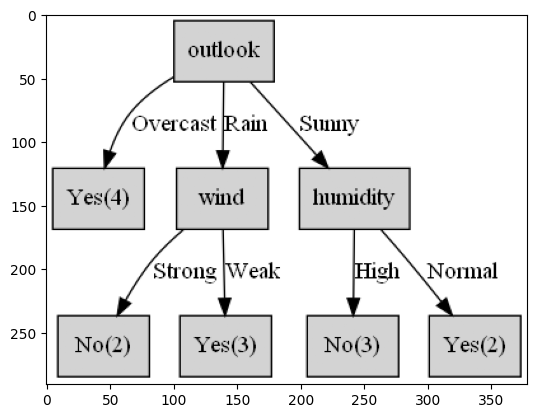

In [58]:
def makeimg(df,target):
    model = Id3Estimator()
    # X = features, y = target
    X = df.drop([target], axis=1).values.tolist()
    y = df[target].values.tolist()
    model.fit(X,y)

    export_graphviz(model.tree_, 'beslissingsboom.dot', feature_names=df.drop([target], axis=1).columns)
    !dot -Tpng beslissingsboom.dot -o beslissingsboom.png

    img = plt.imread('beslissingsboom.png')
    plt.figure()
    plt.imshow(img)
    plt.show()

makeimg(df,'playBall' )

In [62]:
model = Id3Estimator()
# X = features, y = target
X = df.drop(['playBall'], axis=1).values.tolist()
y = df['playBall'].values.tolist()
model.fit(X,y)

model.predict([['Sunny','Mild','High','Weak']])

array(['No'], dtype='<U3')